# Особенности посторения процесса обучения нейронной сети

Больше о настройке обучения нейронных сетей можно найти, например, в:
* [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) от Анедрея Карпатых.
* [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187) - статья 2018 год об обучении сверточных нейронных сетей
* [Tips for Model Training](https://docs.ultralytics.com/guides/model-training-tips/#community-resources) от известной команды `ultralytics` и другие гайд от них и других команд. 
* и в других тематических публикациях известных специалистов, например [тут](https://sebastianraschka.com/blog/2023/pytorch-faster.html), [тут](https://github.com/vahidk/EffectivePyTorch), [тут](https://github.com/rasbt/deeplearning-models)  а также официальные публикации `PyTorch`, [например](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html), и известные коллекции примеров, [например](https://madewithml.com/) или [тут](https://github.com/Conchylicultor/Deep-Learning-Tricks). 
<!-- и [тут](https://stackoverflow.com/questions/70554413/how-to-improve-the-performance-of-cnn-model-for-a-specific-dataset-getting-low). -->
* Важно также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., [например](https://habr.com/ru/companies/wunderfund/articles/820721/).
* А также важно иметь в виду вопросы настройки гиперпараметров обучения нейронных сетей, см., [например](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) и [тут](https://docs.ray.io/en/latest/tune/getting-started.html) и [тут](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html).
* Курс включающий много примеров [тут](https://deeplearning.neuromatch.io/tutorials/W1D5_Optimization/chapter_title.html).
* Гайд [Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook)
* [некоторые заметки](https://habr.com/ru/companies/magnus-tech/articles/846012/)
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

Рецепты в библиотеках
* [`skorch`](https://github.com/skorch-dev/skorch)
* [`bitsandbytes`](https://huggingface.co/docs/bitsandbytes/)

## Импорт

In [9]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy, Precision, Recall, F1Score
import pandas as pd

In [10]:
from torch_trainer import *

Настроим работу с `PyTorch` при помощи функции `setup_experiment`. Выбирем формат работы и устройство для работы.

 Настраивает окружение для воспроизводимых экспериментов в PyTorch.

-  `seed (int)`: Сид для генераторов случайных чисел `(Python, NumPy, PyTorch)`.
-  `deterministic (bool)`: Включить детерминированное поведение операций `CuDNN` (может снизить скорость).
-  `benchmark (bool)`: Включить CuDNN benchmark для автоматического выбора быстрых алгоритмов (не совместимо с `deterministic=True`).
-  `allow_tf32 (bool)`: Разрешить использование TensorFloat32 на Ampere+ GPU (ускоряет вычисления с небольшой потерей точности).
-  `device_preference (str)`: `"cpu", "cuda", "mps"`, или `"auto"` — выбор устройства.

возвращается Устройство, на котором будут выполняться вычисления.

In [11]:
device = setup_experiment(seed=42, device_preference="auto")

[✓] Device: cuda | Seed: 42 | TF32: True


# Обзор библиотеки `timm`

In [12]:
import timm

Библиотека [timm (PyTorch Image Models)](https://huggingface.co/timm) один из самых востребованных инструментов для задач компьютерного зрения по  классификации изображений, а также для построения мощных `feature extractor` для более сложных архитектур. [Библиотека `timm`](https://github.com/huggingface/pytorch-image-models) поддерживает более 1000 предобученных моделей и имеет тесную интеграцию с экосистемой `Hugging Face`.

<!-- [Библиотека `timm`](https://huggingface.co/docs/timm/index) предоставляет встроенная поддержка `transfer learnin`: — например, замену головной части классификатора под нужное число классов или указание количество входных каналов (обычно 3 для `RGB`-изображений или 1 для `grayscale`). Это особенно удобно при работе с нестандартными доменами — от медицинских снимков до спутниковых изображений.

Помимо моделей, [библиотека `timm`](https://github.com/huggingface/pytorch-image-models) предоставляет готовые и согласованные пайплайны обработки данных, включая автоматическую настройку аугментаций и нормализации под конкретную архитектуру через `timm.data.create_transform()` и `resolve_data_config()`. Это гарантирует, что входные данные будут обработаны так же, как и при оригинальном предобучении — критически важное условие для стабильной и точной инференции.

[Библиотека `timm`](https://huggingface.co/docs/timm/index) полностью совместим с `Hugging Face Hub`: модели можно не только загружать напрямую из репозиториев `Hugging Face`, но и публиковать собственные веса, делая их доступными для сообщества. Такая интеграция упрощает воспроизводимость экспериментов и совместную работу. -->




Модели в `Timm` можно найти при помощи [поисковика hugging face](https://huggingface.co/models?pipeline_tag=image-classification&library=timm,pytorch&sort=trending) или функции  `list_models` как это показано ниже.

In [17]:
model_names = timm.list_models('mobilenetv3*')
print(model_names[:15])

['mobilenetv3_large_075', 'mobilenetv3_large_100', 'mobilenetv3_large_150d', 'mobilenetv3_rw', 'mobilenetv3_small_050', 'mobilenetv3_small_075', 'mobilenetv3_small_100']


В данном уроке посмотрим на работу с `TIMM` на  примере архитектуры типа `mobilenetv3_small`. Эта архитектура представляет собой модификацию архитектуры `mobilenet v3`.

<!-- В коде ниже

* `timm.create_model` — функция из библиотеки `timm` для загрузки архитектур нейронных сетей.

* `mobilenetv3_small_050` — название архитектуры конкрейтной: `mobilenet v3`.

* `pretrained=True` — загрузка весов, предварительно обученных на `ImageNet`.

* `num_classes=2` — количество классов на выходном слое (модель перестраивается под задачу бинарной классификации).

* `in_chans=3` — число входных каналов (3 соответствует `RGB`‑изображениям). -->



In [7]:
model = timm.create_model('mobilenetv3_small_050', pretrained=True, num_classes=2, in_chans=3)

<blockquote>

Отметим, что при наличии локальной предобученной модели ее можно загрузить как чекпоинт

```python
    model = timm.create_model(
    'resnet18',
    pretrained=False,
    checkpoint_path='/path/to/resnet18.pth'  # путь к локальному .pth
)
```

</blockquote>

In [18]:
model.eval() 
with torch.inference_mode():
    out = model(torch.randn(7, 3, 224, 224))
    
print(f'Logits shape: {out.shape}')  

Logits shape: torch.Size([7, 2])


Для такой модели, например, можно отдельно вызвать `feature_extractor` (`backbone`).

Параметры:
* `num_classes=0` — убирает классификатор,
* `global_pool=''` — отключает глобальный пуллинг.

In [20]:
backbone = timm.create_model('mobilenetv3_small_050', 
                             pretrained=True, 
                             num_classes=0, 
                             global_pool='')  # no head
features = backbone(torch.randn(7, 3, 224, 224))  
print(f"Feature map shape: {features.shape}")

Feature map shape: torch.Size([7, 1024])


Аналогично для модели с указанной головной частью можно получить головную часть при помощи метода `get_classifier` и заменить ее при помощи метода `reset_classifier`

In [21]:
model = timm.create_model('mobilenetv3_small_050', pretrained=True)

In [22]:
model.get_classifier()

Linear(in_features=1024, out_features=1000, bias=True)

In [23]:
model.reset_classifier(num_classes=2)
print(model.get_classifier())  # → Linear(in_features=512, out_features=2, bias=True)

Linear(in_features=1024, out_features=2, bias=True)


Чтобы заморозить `backbone`, можно при помощи указанных методов сделать следующее

In [24]:
for param in model.parameters():
    param.requires_grad = False
model.get_classifier().requires_grad_(True)

Linear(in_features=1024, out_features=2, bias=True)

Аналогично можно попытаться заменить головную часть на кастомную

In [25]:
custom_head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 2)  # 2 класса
)

In [26]:
model.classifier = custom_head  

<!-- Аналогично можно создать новые преобразования при помощи `create_transform`

Важные замечания
1. `create_transform` ожидает `PIL.Image` на входе, а не с `ndaray` или `torch.tensor`.
2. Поэтому если открываете датасет вручную, то всегда делайте:
`Image.open(path).convert("RGB")`
3. Не применяйте `ToTensor()` вручную!
`create_transform` уже включает `ToTensor()` и `Normalize()` — не добавляйте их дважды!
4. Для валидации — только детерминированные преобразования. Никаких случайных аугментаций (если вы не делаете `test time augmentation` конечно)!
`is_training=False` → только `Resize, CenterCrop, ToTensor, Normalize`. -->

Отметим, что на самом деле в `timm` представлен достаточно широкий функционал, включая возможность:
- создание преобрзований  при помощи `create_transform`
- создание оптимизаторов при помощи `create_optimizer_v2`
- создание планировщиков обучения  при помощи `create_scheduler_v2`
- создание датасетов и загрузчиков данных, а также еще целый ряд фунций.
- однако, данный функционал почти не представлен в документации и его работоспособность соответственно не гарантируется!

# Настройка обучения модели

## Датасет

In [26]:
from torchinfo import summary
from torchvision import transforms, datasets
from torchvision.datasets.utils import download_and_extract_archive

In [27]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

In [28]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
BATCH_SIZE  = 16

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN,STD)
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),transform)
valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'), transform)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True)
valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, )

num_classes = len(traindata.classes)

## Оптимизатор

Наиболее [простые и популярные](https://docs.pytorch.org/docs/stable/optim.html) оптмизаторы могут быть найдены ниже

> Отдельно отметим возможность также использовать более продвинутые и современные оптимизаторы из [HuggingFace bitsbytes](https://huggingface.co/docs/bitsandbytes/main/en/reference/optim/optim_overview) или напримере библиотеки [torch_optimizer](https://github.com/jettify/pytorch-optimizer) или [timm](https://huggingface.co/docs/timm/en/reference/optimizers).
>
> Также отметим существование [алгоритмов поиска оптимального `Learning rate`](https://github.com/davidtvs/pytorch-lr-finder). Однако известная реализация устарела и не обновляется. Имеется также реализация в `pytorch_lighting`
>
> Также [`LR` зависит от `BatchSize`](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). Чем больше батч - тем больше `LR`

| Оптимизатор                              | Плюсы                                                                 | Минусы                                                                 | Когда использовать                                                                 |
|------------------------------------------|------------------------------------------------------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| **SGD + momentum** / **SGD + Nesterov**  | - Простой и надёжный<br>- Хорошо обобщает<br>- Часто даёт лучшие результаты при тонкой настройке | - Требует тщательного подбора learning rate<br>- Медленная сходимость   | - Базовые модели (ResNet, VGG)<br>- Когда важна обобщающая способность<br>- При наличии хорошего LR scheduler'а |
| **Adam / AdamW / NAdam / Adamax**        | - Адаптивные learning rate<br>- Быстрая сходимость<br>- Мало чувствителен к начальному LR | - Хуже обобщает по сравнению с SGD<br>- Может «застревать» в плохих минимумах | - Быстрый прототип / эксперимент<br>- Маленькие датасеты<br>- Когда не критична обобщающая способность |
| **RMSprop**                              | - Хорош для рекуррентных сетей и некоторых CV задач (например, в старых EfficientNet) | - Редко используется в современных CV моделях                          | - Legacy код<br>- Некоторые мобильные архитектуры                                   |

```python
optimizer = torch.optim.SGD(...,
    lr=0.1,               # часто 0.1 для ImageNet, 0.01–0.001 для малых датасетов
    momentum=0.9,
    weight_decay=1e-4     # для ResNet/VGG
    nesterov=True # для Nesterov
)

optimizer = torch.optim.Adam(...,
    lr=3e-4,               # типичный "магический" LR
    weight_decay=0         # ← Adam не совместим с L2-regularization напрямую!
)    

optimizer = torch.optim.AdamW/NAdam/Adamax(  ...    weight_decay=1e-2 )    # ← теперь корректная декуплинговая регуляризация

optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=1e-3,
    alpha=0.99,            # decay
    eps=1e-8,
    weight_decay=1e-5,
    momentum=0.9           # иногда добавляют
)                                        
```

CМ. Больше оптимизаторов в [pytorch_optimizer](https://github.com/kozistr/pytorch_optimizer).

<blockquote>
    

Иногда при использовании предобученных сетей используется гипотеза заключается в том, что ранние слои нейронной сети учатся извлекать более общие признаки, в то время как поздние слои учатся извлекать более специфичные для конкретной задачи признаки. Если это так, то общие признаки, извлекаемые ранними слоями, должны быть полезны для любой задачи, и мы должны изменять их предварительно обученные веса на очень небольшую величину — если вообще должны.

Дискриминативную тонкую настройку параметров обучения обычно нет необходимости использовать при обучении модели на основе случайно инициализированных весов.

```python

LR = 1e-2;

params = [
          {'params': model.feature_extractor.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters(), 'lr': LR }
         ]

optimizer = optim.Adam(params, lr=LR)
```

Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отдельным параметрам. Например, если используется `SGD with weight_decay`, иногда полезно отключить `weight_decay` для параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

</blockquote> 

In [65]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

## Планировщик обучения

Другим полезным приемом будет использовать [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае планировщик скорости обучения задается из пакета `torch.optim.lr_scheduler` как одноцикловой планировщик. То есть он имеет только один цикл изменения скорости. 

Ниже показан пример визуализации для 4 типов планировщиков. 

> * Обратите внимание, что текущее значение скорости обучения можно получить как `optimizer.param_groups[0]["lr"]`.  
> * Также скорость може быть и установлена `optimizer.param_groups[0]["lr"]  = 0.01`
> * Всегда визуализируйте LR перед запуском долгого обучения.
> * Для fine-tuning: начинайте с LR в 10–100× меньше, чем при pre-training.
> * Используйте warmup, если batch size большой или данные зашумлены.

<blockquote>
    
Отметим, что также может быть использован планировщик `ReduceLROnPlateau`, который снижает скорость обучения автоматически при выходе валидации на плато.
    
```python

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(10):
        train(...)
        val_loss = validate(...)
        # Note that step should be called after validate()
        scheduler.step(val_loss)
```

Следует также отметить, что помимо расписания ниже приведен следующий код:
```python
    max_grad = 10
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))
```

Такой прием позволяет ограничить значение градиента (`gradient clipping`): `lambda grad: torch.clamp(grad, -0.1, max_grad)`. Прием применяется для всех параметров, так как задан цикл. При этом данный прием записывается как дополнительная функция при расчете градиента. Это реализовано через т.н. `hook`. По средствам метода `register_hook` подобно `callback` каждому параметру ставится дополнительная функция в соответствие.

Отметим, следующие [практики использования изменяющейся скорости обучения](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers):
* __Начните с фиксированной скорости__. Начните обучение с постоянной скорости обучения, чтобы установить базовый уровень и обеспечить начальную сходимость.
* __Настройте параметры планировщика__. Размер шага (`step_size`), гамма (`gamma`) и другие параметры планировщика сильно влияют на производительность модели. Поэкспериментируйте с различными настройками, чтобы найти оптимальный вариант для ваших данных и модели.
* __Следите за потерями и метриками__. Следите за метриками обучения и проверки. Планировщики скорости обучения могут помочь точно настроить модель, адаптируясь к ее изменяющимся потребностям во время обучения.

Когда следует использовать планирование скорости обучения:
* __Разреженные данные__. Для данных с разреженными признаками планирование может помочь модели сосредоточиться на менее распространенных признаках, тем самым повышая производительность.
* __Медленно и быстро обучающиеся признаки__. Не все признаки должны обновляться с одинаковой скоростью. Например, в нейронных сетях весам более ранних слоев может потребоваться больше времени для сходимости. Планирование может помочь ускорить их обновление.
* __Плато потерь__. Когда функция потерь сглаживается, указывая на то, что модель мало чему учится при текущей скорости обучения, планировщик может снизить скорость и вывести модель из колеи.

C:\Users\Ronkin\anaconda3\envs\py39\lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


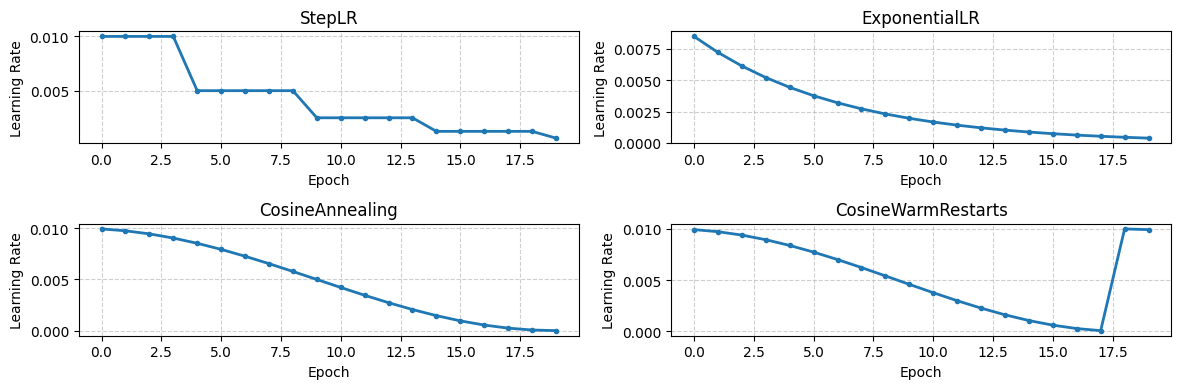

In [29]:
import matplotlib.pyplot as plt

# Гиперпараметры
epochs = 20
initial_lr = 0.01

# Создаём "фиктивный" оптимизатор (только для LR)
dummy_model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(dummy_model.parameters(), lr=initial_lr)

schedulers = {
    'StepLR': torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5),
    'ExponentialLR': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85),
    'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6),
    'CosineWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=19, T_mult=1, eta_min=1e-6
    )
}

# Собираем LR по эпохам
lrs = {}
for name in schedulers:
    lrs[name] = []

for name, scheduler in schedulers.items():

    for param_group in optimizer.param_groups:
        param_group['lr'] = initial_lr

    for epoch in range(epochs):
        scheduler.step()
        lrs[name].append(optimizer.param_groups[0]['lr'])
        
# Визуализация
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs = axs.ravel()

for i, (name, lr_vals) in enumerate(lrs.items()):
    axs[i].plot(range(epochs), lr_vals, marker='o', linewidth=2, markersize=3)
    axs[i].set_title(name, fontsize=12)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Learning Rate')
    axs[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## Метрики обучения

Метрики обучения возьмем из библиотеки [`torchmetrics`](https://github.com/Lightning-AI/torchmetrics) для библиотеки есть актуальный [GitHub](https://github.com/Lightning-AI/torchmetrics)  и [очень старая документация](https://torchmetrics.readthedocs.io/en/v0.8.2/index.html).

Для объектов классов заданных метрик также используем т.н. "захват функции" (`wrapped_metrics`) - получение объекта класса из заданного в словаре класса.

In [30]:
from torchmetrics import *

In [31]:
metrics = {
    "acc": Accuracy(task="multiclass", num_classes=num_classes).to(device),
    "prec": Precision(task="multiclass", num_classes=num_classes, average="macro").to(device),
    "rec": Recall(task="multiclass", num_classes=num_classes, average="macro").to(device),
    "f1": F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device),
}
# Оборачиваем для совместимости
wrapped_metrics = {k: lambda pred, target, fn=fn: fn(pred, target) for k, fn in metrics.items()}

In [32]:
wrapped_metrics

{'acc': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassAccuracy())>,
 'prec': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassPrecision())>,
 'rec': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassRecall())>,
 'f1': <function __main__.<dictcomp>.<lambda>(pred, target, fn=MulticlassF1Score())>}

> Напомним, что
>
> * `average="macro"` - среднее по классам,
>  * `average="micro"` - среднее по всем записям
>  * Разница важна для метрик `Precision, Recall, F1Score` при работе с несбалансированными классами.

# Кросс-валидация

* k-folds: 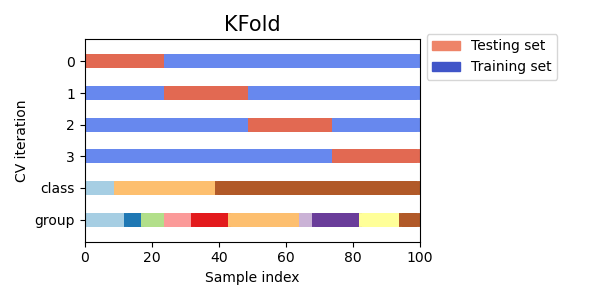
* Stratified K-fold: 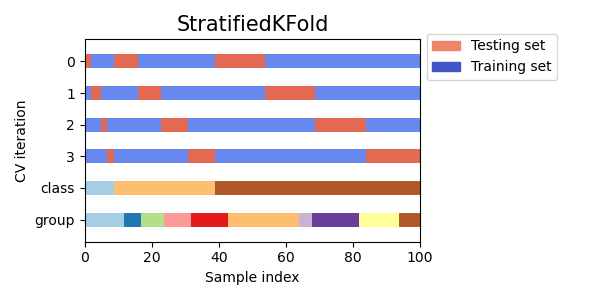
* Nested CV: 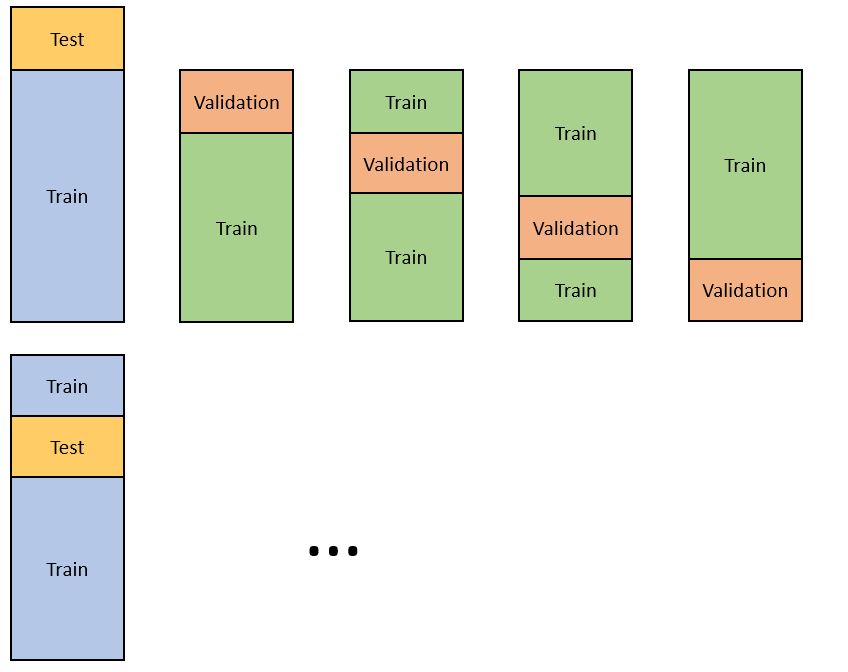 

## Функция потерь

<blockquote>
 
 Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing), выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K] $$ где $\eta$ — весовой коэффициент, $K$ — число классов, а $U[0, \eta/K]$ — равномерное распределение. То есть $y_s$ представляет собой вектор, где основной класс имеет значение в диапазоне $(0,1)$, а остаток этого диапазона «размыт» между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. 
```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```
 </blockquote>

## Обучение модели

### Загрузка модели.

In [33]:
model = timm.create_model('mobilenetv3_small_050', 
                          pretrained=True, 
                          num_classes=len(traindata.classes), 
                          in_chans=3)

for param in model.parameters():
    param.requires_grad = False
model.get_classifier().requires_grad_(True)

def init_classifier(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Применяем ТОЛЬКО к голове
model.classifier.apply(init_classifier)

Linear(in_features=1024, out_features=2, bias=True)

In [34]:
summary(model, (1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [1, 2]                    --
├─Conv2d: 1-1                                 [1, 16, 112, 112]         (432)
├─BatchNormAct2d: 1-2                         [1, 16, 112, 112]         32
│    └─Identity: 2-1                          [1, 16, 112, 112]         --
│    └─Hardswish: 2-2                         [1, 16, 112, 112]         --
├─Sequential: 1-3                             [1, 288, 7, 7]            --
│    └─Sequential: 2-3                        [1, 8, 56, 56]            --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 8, 56, 56]            (600)
│    └─Sequential: 2-4                        [1, 16, 28, 28]           --
│    │    └─InvertedResidual: 3-2             [1, 16, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-3             [1, 16, 28, 28]           (2,552)
│    └─Sequential: 2-5                        [1, 24, 14, 14]           --
│   

In [72]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print('trainable p:', trainable_params, 'all p:', total_params)

trainable p: 2050 all p: 570274


In [35]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.AdamW(trainable_parameters, lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3)
criterion=torch.nn.CrossEntropyLoss().to(device)
model.to(device);


### Обучение модели

In [36]:
history = fit(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    optimizer=optimizer,
    scheduler = scheduler,
    criterion=criterion,
    metrics=wrapped_metrics,
    device=device,
    epochs=30,
    patience=7,
    monitor_metric="f1",
    mode="max",
    use_amp=(device.type == "cuda"),
    ema_decay=0.999,
    grad_clip=1.0,
    accumulation_steps=1,
    checkpoint_path="best_model.pt",
)

Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01 | Time: 14.4s | LR: 3.00e-04 | Train Loss: 0.6773 | Val Loss: 0.6847 | Val f1: 0.3845 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 02 | Time: 1.4s | LR: 3.00e-04 | Train Loss: 0.6247 | Val Loss: 0.6828 | Val f1: 0.3977 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 03 | Time: 1.3s | LR: 3.00e-04 | Train Loss: 0.5798 | Val Loss: 0.6791 | Val f1: 0.4061 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 04 | Time: 1.3s | LR: 3.00e-04 | Train Loss: 0.5413 | Val Loss: 0.6759 | Val f1: 0.4193 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 05 | Time: 1.3s | LR: 3.00e-04 | Train Loss: 0.5092 | Val Loss: 0.6742 | Val f1: 0.4365 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 06 | Time: 1.5s | LR: 3.00e-04 | Train Loss: 0.4850 | Val Loss: 0.6698 | Val f1: 0.4896 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 07 | Time: 1.6s | LR: 3.00e-04 | Train Loss: 0.4734 | Val Loss: 0.6665 | Val f1: 0.4422 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 08 | Time: 1.5s | LR: 3.00e-04 | Train Loss: 0.4253 | Val Loss: 0.6611 | Val f1: 0.5092 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 09 | Time: 1.4s | LR: 3.00e-04 | Train Loss: 0.4269 | Val Loss: 0.6568 | Val f1: 0.5124 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Time: 1.3s | LR: 3.00e-04 | Train Loss: 0.3911 | Val Loss: 0.6515 | Val f1: 0.5153 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Time: 1.4s | LR: 3.00e-04 | Train Loss: 0.3708 | Val Loss: 0.6470 | Val f1: 0.5383 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Time: 1.4s | LR: 3.00e-04 | Train Loss: 0.3646 | Val Loss: 0.6403 | Val f1: 0.5976 ★


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Time: 1.6s | LR: 3.00e-04 | Train Loss: 0.3771 | Val Loss: 0.6364 | Val f1: 0.4888 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Time: 1.4s | LR: 3.00e-04 | Train Loss: 0.3389 | Val Loss: 0.6294 | Val f1: 0.5421 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Time: 1.4s | LR: 3.00e-04 | Train Loss: 0.3374 | Val Loss: 0.6227 | Val f1: 0.4870 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Time: 1.4s | LR: 3.00e-05 | Train Loss: 0.3326 | Val Loss: 0.6162 | Val f1: 0.5462 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Time: 1.4s | LR: 3.00e-05 | Train Loss: 0.3335 | Val Loss: 0.6107 | Val f1: 0.5385 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Time: 1.4s | LR: 3.00e-05 | Train Loss: 0.3248 | Val Loss: 0.6048 | Val f1: 0.5462 


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Time: 1.5s | LR: 3.00e-05 | Train Loss: 0.3087 | Val Loss: 0.5972 | Val f1: 0.5544 
Early stopping at epoch 19. Best: 0.597581 at epoch 12


## Задания

**1.** Проверьте, как влияют те или иные режимы инициализации на качество работы нейронной сети. Например, инициализация постоянными величинами `nn.init.constant_(m.weight, constant_weight)`.

__2.__  В ряде [случаев](https://discuss.pytorch.org/t/tricks-for-being-able-to-use-a-higher-learning-rate/142179) рекомендуется стратегия обучения, когда изначально используется крайне низкая скорость обучения в течение нескольких эпох, чтобы веса модели настроились в нужном направлении. Такие эпохи будут сравнительно бесполезными с точки зрения результата обучения, но повышают стабильность экспериментов. Затем скорость обучения резко увеличивают и начинают плавно снижать. Предполагается, что после первоначальной настройки весов они могут быстро обучиться в нужном направлении. __Предлагается__ реализовать эту стратегию самостоятельно.

> Также иногда используют циклическую скорость обучения для большого числа эпох.

<code style="color : red">__3.*__</code> В ряде [работ](https://openreview.net/pdf?id=B1Yy1BxCZ) рекомендуется вместе с изменением скорости обучения (с ее снижением) [увеличивать размер батча](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). __Предлагается__ реализовать эту стратегию обучения самостоятельно. 

> [Иногда](https://ar5iv.labs.arxiv.org/abs/1803.09820) также рекомендуют уменьшать затухание весов с ростом эпохи обучения (параметр `L2` регуляризации — `weight_decay` в оптимизаторах). Если используется параметр `momentum`, то он должен снижаться с увеличением скорости обучения [или циркулировать](https://ar5iv.labs.arxiv.org/abs/1803.09820).

<code style="color : red">__4.*__</code> Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отдельным параметрам. Например, если используется `SGD with weight_decay`, иногда полезно отключить `weight_decay` для параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

__Предлагается__ проверить качество такого оптимизатора самостоятельно.

<code style="color : red">__5.*__</code> Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing), выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K] $$ где $\eta$ — весовой коэффициент, $K$ — число классов, а $U[0, \eta/K]$ — равномерное распределение. То есть $y_s$ представляет собой вектор, где основной класс имеет значение в диапазоне $(0,1)$, а остаток этого диапазона «размыт» между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. __Предлагается__ попробовать использовать эту функцию самостоятельно.

```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```